<h2 style = "text-align: center;">Advanced Data Science for Traffic and Transportation Engineering</h2>

<h3 style = "text-align: center;">Determine the Position of Road Inspectors - Rijkswaterstaat</h3><br><br>

<div style="display:flex">
     <div style="flex:1;padding-right:10px;">
          <h3 style = "text-align: left;">Group 3</h3>
        <ul>
            <li>Yiman Bao (5691648)</li>
            <li>Juan Camargo Fonseca (5834112)</li>
            <li>Tijmen Hoedjes (4959183)</li>
            <li>Max Lange (5169402)</li>
            <li>Wail Abdellaoui (5130654)</li>
        </ul>
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="Images/TUDelft_logo.jpg" width="300"/>
     </div>
</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from datetime import datetime
import geopandas as gpd
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
import networkx as nx

import data_filtering

# 1 Probability of the incident

## 1.1 Import data and filter the data

In [2]:
#Extract subnetwork
highway_shapefile = 'Data/Shapefiles/Snelheid_Wegvakken.shp'
road_network = gpd.read_file(highway_shapefile)
# road_network = road_network.to_crs("EPSG:4326")

In [3]:
path = 'Data/incidents19Q3Q4.csv'
df_incident = pd.read_csv(path)
df_incident['starttime_new'] = pd.to_datetime(df_incident['starttime_new'])
df_incident['endtime_new'] = pd.to_datetime(df_incident['endtime_new'])
df_incident = data_filtering.filter_out(df_incident, road_network)

## 1.2 Kernel Density Estimation

Kernel Density Estimation (KDE) is a non-parametric statistical method used to estimate the probability density function (PDF) of a random variable. It helps us to convert discrete incident data points into incident probability densities on the map. KDE builds on the assumption that the samples drawn for a population are independent and identically distributed (i.i.d), an assumption that holds for the project's context in most occasions.<br><br>

KDE has two key parameters: Kernel and Bandwidth. Kernel selection defines the shape of the obtained density function will have, some kernel examples are gaussian, tophat, epanechnikov, exponential, linear and cosine; for this project we chose the gaussian kernel as it's pdf never evaluates to zero, meaning that accidents also can occur in other network locations, but with a lower probability. On the other hand we have the bandwidth, which is perhaps a more important parameter than the kernel as it determines the smoothness of the density function. An excessively large bandwidth will make the probability density distribution more blurry, and thus unable to capture non-unimodal characteristics the data may have, this is also referred to as oversmoothing; on the other hand, a lower bandwidth will bring undersmoothing into the picture, which makes it more difficult to obtain the probability by subsequent integration, as the density function will look more like a combination of individual peaks. Appropriate bandwidth selection is a study field on its own, with different approaches being used. Currently, we choose the averge road section in the road network as the bandwidth, which can help us to get the probability of the section, for further developments, a more comprehensive approach can be used.


In [4]:
#bandwidth = 0.05
bandwidth = np.mean(road_network['geometry'].length)
accident_coords = df_incident[['primaire_locatie_lengtegraad', 'primaire_locatie_breedtegraad']].values.T
# kde estimate
kde = gaussian_kde(accident_coords, bw_method=bandwidth)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14080\3692850434.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bandwidth = np.mean(road_network['geometry'].length)


In order to get the incident probability for each section, we use a simple way to save the code running time. We get the density at the midpoint of each road section from the KDE result and then multiply by road length to get probability. Afterwards, the result of it is also normalized. Note that the bandwidth selection is very important for this step, as a very small or very small bandwith will make the midpoint density value lose representativeness of the segment condition.

In [5]:
road_network['Accident_Density'] = np.nan

for idx, row in road_network.iterrows():
    # Calculate the accident density at the midpoint of each road network segment
    density = kde([row.geometry.centroid.x, row.geometry.centroid.y])
    road_network.at[idx, 'Accident_Density'] = density[0]

road_network['Unnormalized_Probability'] = road_network['Accident_Density'] * road_network['geometry'].length
road_network['Normalized_Probability'] = road_network['Unnormalized_Probability'] / sum(road_network['Unnormalized_Probability'])

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14080\204063085.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  road_network['Unnormalized_Probability'] = road_network['Accident_Density'] * road_network['geometry'].length


The result is shown as heatmap.

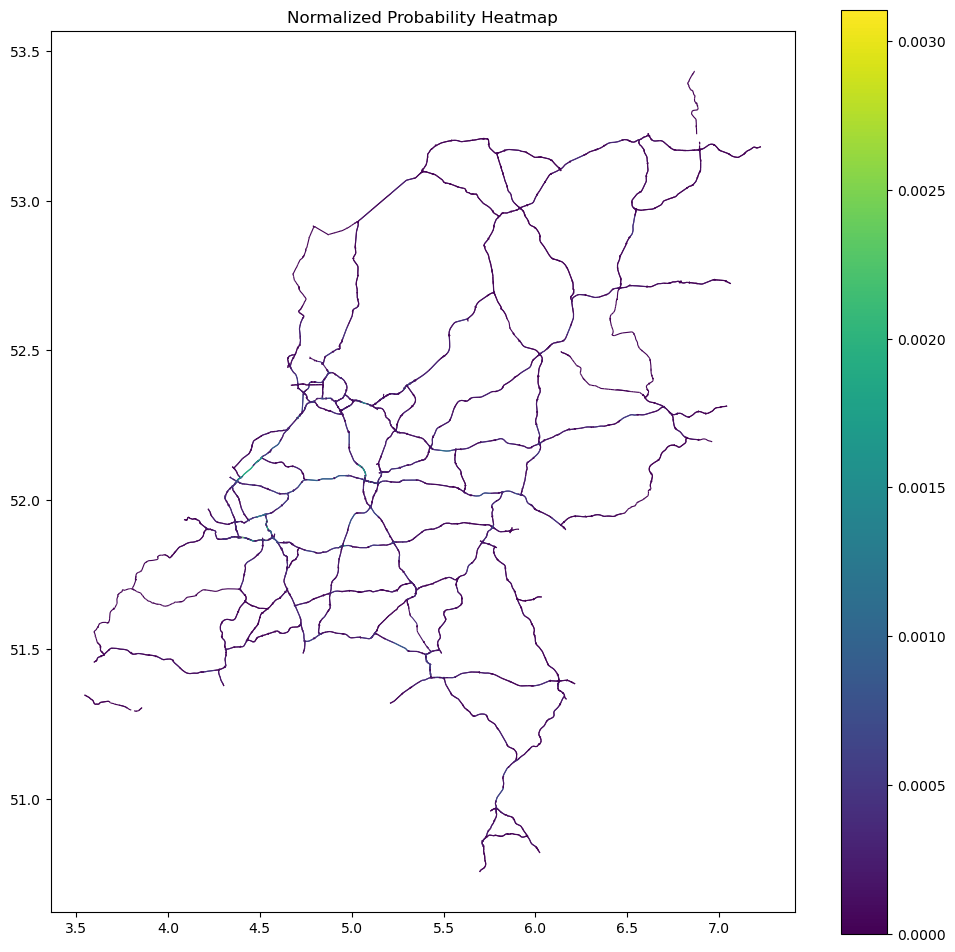

In [6]:
heatmap_gdf = road_network[['geometry', 'Normalized_Probability']].copy()
fig, ax = plt.subplots(figsize=(12, 12))
cmap = 'viridis'  
heatmap_gdf.plot(column='Normalized_Probability', cmap=cmap, linewidth=0.8, ax=ax, legend=True)
plt.title('Normalized Probability Heatmap')
plt.show()

In [7]:
dutch_road_network = road_network.to_crs("EPSG:28992")

In [8]:
G_NL2 = nx.Graph()

for index, row in dutch_road_network.iterrows():

    line = row.geometry

    start_node = line.coords[0]
    end_node = line.coords[-1]

    G_NL2.add_node(start_node)
    G_NL2.add_node(end_node)

    G_NL2.add_edge(start_node, end_node, geometry=line, weight = row['Normalized_Probability'])
print(f"Number of nodes: {G_NL2.number_of_nodes()}")
print(f"Number of edges: {G_NL2.number_of_edges()}")

Number of nodes: 13356
Number of edges: 13945


In [9]:
amatrix = nx.adjacency_matrix(G_NL2).todense()
copy_amatrix = amatrix.copy()

leaf_pos = []
node_weights = []

# Determine which nodes are leaf nodes (only one connection)
for i,row in enumerate(copy_amatrix):
    nonzero = np.count_nonzero(row)
    if nonzero == 1:
        leaf_pos.append(i)

# Duplicate column values in amatrix according to the number of zeros in the row
for i in leaf_pos:
    amatrix[:, i] *= 2

# If the row position is in zeros_pos, append zeros to the weigths, otherwise split the edges weight evenly
for i,row in enumerate(copy_amatrix):
    if i in leaf_pos:
        node_weights.append(0)
    else:
        node_weights.append(np.sum(row)/2)
        

In [10]:
probs_gdf = gpd.GeoDataFrame(columns=['name', 'node_weight', 'geometry'])

for i, node in enumerate(list(G_NL2.nodes())):
    name = i  
    node_weight = node_weights[i]
    geometry = Point(node)

    probs_gdf.loc[i] = [name, node_weight, geometry]

In [11]:
probs_gdf

,name,node_weight,geometry
0,0,0.000000,POINT (117613.756 426301.388)
1,1,0.000040,POINT (117836.772 426330.494)
2,2,0.000020,POINT (231708.389 525975.794)
3,3,0.000147,POINT (231916.922 525977.286)
4,4,0.000094,POINT (199413.841 563825.916)
...,...,...,...
13351,13351,0.000000,POINT (278022.270 578647.114)
13352,13352,0.000000,POINT (79362.959 400606.382)
13353,13353,0.000000,POINT (238367.493 580282.491)
13354,13354,0.000000,POINT (121938.845 500667.129)


# 2 Algorithm I

## 2.1 The basic idea

## The Algorithm: Marching Leaf Nodes
Having assigned the accidents to the nodes in our network, we now use these accidents counts as a representation for the probability that a accident occurs in our network. We do this by deviding the accident counts of all nodes by the total number of allocated accidents, so that the sum of all probabilities is 1.

For the allocation of inspector we have a few rules to which our algorithm must comply:
1. All nodes in the network must be within reach of an inspector according to the travel time limit
2. The total probability of the nodes allocated to a single inspector must be within a given limit
3. All nodes allocated to an inspector must reachable within the travel time limit from at least one of the allocated nodes

With these rules, the following algorithm for placing a single inspector was devised:
1. We start at a leaf node of the network (leaf node = only one connecting edge). This way we prevent inspectors being placed in such a way that some leaf nodes fall just outside the coverage of the inspectors, requiring an entire extra inspector just to cover that leaf node. Starting with the leafs eliminates this issue.
2. Look at the reachable neighbours (keeping in mind the travel direction) of the node. Select the closest one. Add this closest neighbour to the list of nodes coverered by the inspector.
3. Check if the sum of the probabilities of the inspector's nodes are below the set thershold, if so continue, if not go to 'finish inspector network'
4. Check if the the inspector's nodes are all reachable within the travel time limit from at least one of the nodes (for this dijkstra shortest path algorithm is used), if so continue, if not go to 'finish' inspector network.
5. It seems that all checks are satisfied, the neighbour node is definitly added to the inspectors nodes. This node takes over the role of the leaf node from step 1, and we go back to step 2 using this new node.
6. 'Finish inspector network'. One of the checks has failed, meaning the inspector's personal network is at capacity for either total probability or travel time. We remove the added neighbour node, as that caused one of the checks to fail. We also look which node in the inspector's node gives the most central placement, and save that location as the node to place the inspector at. A single inspector placement is made.

With this placement loop, we can go through the entire network. Once a inspector placement has been made, the nodes which that inspector covers are removed from the main network. This way once a new inspector placement is made it cannot consider already covered nodes. It also means that leaf nodes are constantly created, as removing nodes and edges from the network in this way always creates new leafes. Once going through all the existing leaf-nodes, we repeat the loop again with the newly created leaf nodes, and repeat this cycle until the entire network is covered.


## 2.1 Coding

### 2.1.1 Convert road network to graph

In [12]:
# Convert data to node and edge GeoDataFrames containing only needed info
points = {'name': [], 'geometry': []}
edges = {'from': [], 'to': [], 'type': [], 'direction': [], 'name': [], 'geometry': []}

for _, row in dutch_road_network.iterrows():
    if row['JTE_ID_BEG'] not in points['name']:
        points['name'].append(row['JTE_ID_BEG'])
        points['geometry'].append(Point(row['geometry'].coords[0]))
    
    if row['JTE_ID_END'] not in points['name']:
        points['name'].append(row['JTE_ID_END'])
        points['geometry'].append(Point(row['geometry'].coords[-1]))
    
    edges['from'].append(row['JTE_ID_BEG'])
    edges['to'].append(row['JTE_ID_END'])
    edges['type'].append(row['BST_CODE'])
    edges['direction'].append(row['RIJRICHTNG'])
    edges['name'].append(row['STT_NAAM'])
    edges['geometry'].append(row['geometry'])

points_gdf = gpd.GeoDataFrame(points)
edges_gdf = gpd.GeoDataFrame(edges)

In [13]:
points_gdf['probability'] = points_gdf['geometry'].map(probs_gdf.set_index('geometry')['node_weight'])

In [14]:
NWB_Graph = nx.Graph()

for _, point in points_gdf.iterrows():
    NWB_Graph.add_node(point['name'], pos=point['geometry'].coords[0], probability=point['probability'])

already_connected = []
crossroads_id = 1
for index, edge in edges_gdf.iterrows():
    NWB_Graph.add_edge(edge['from'], edge['to'], geom=edge['geometry'], weight=edge['geometry'].length)

    if edge['type'] in ['AFR', 'OPR'] and index not in already_connected:
        to_connect = edges_gdf[edges_gdf['name'] == edge['name']]
        to_connect = to_connect[to_connect['type'].isin(['AFR', 'OPR'])]

        # Add a node
        x = []
        y = []
        # TODO: add check for if direction is 'H' / add functionality to deal with other directions than 'H'
        for _, i in to_connect.iterrows():
            x.append(i['geometry'].coords[-1][0])
            y.append(i['geometry'].coords[-1][1])
        x = np.sum(x) / len(to_connect)
        y = np.sum(y) / len(to_connect)
        NWB_Graph.add_node(crossroads_id, pos=(x, y), probability=0)

        # Connect all to nodes to new node
        for index, i in to_connect.iterrows():
            already_connected.append(index)
            NWB_Graph.add_edge(i['to'], crossroads_id, geom=None, weight=0)

        crossroads_id += 1

print(crossroads_id)
print(NWB_Graph.size())

686
17092


### Define Algorithm

In [15]:
max_dist = 30_000  # Max distance which can be travelled in 18 minutes while going 100 km/h
max_prob = 1  # Variable to configure the algorithm by

# TODO: For now this only works for undirected graph, create a system for directed ones (using successor and predeccesor for neighbors)
# TODO: Can we add edges and from one graph to another directly? Instead of this copying data
# TODO: Maybe look at starting at exit points, allowing only those to be legitimate placements for inspectors

def single_inspector_placement(name, total_graph: nx.Graph):
    # print(f"Starting placement at node {name}")
    inspector_graph = nx.Graph()
    inspector_graph.add_node(name,
                             pos=total_graph.nodes[name]['pos'],
                             probability=total_graph.nodes[name]['probability'])
    prob_sum = total_graph.nodes[name]['probability']

    # Node addition loop
    node_added = True
    possible_additions = {}
    while node_added is True:
        node_added = False

        # Construct list of all possible neighbours to add
        neighbours = [neighbour for neighbour in total_graph.neighbors(name)]
        for neighbour in neighbours:
            if neighbour not in inspector_graph.nodes:
                possible_additions[neighbour] = (name, total_graph.edges[name, neighbour]['weight'])
        # Sort value by lowest distance
        possible_additions = dict(sorted(possible_additions.items(), key=lambda item: item[1][1]))

        # Check if any of the possible additions meet the requirements
        for possible_add in possible_additions:
            # Check for maximum probability requirement
            if prob_sum + total_graph.nodes[possible_add]['probability'] < max_prob:

                # Add node to inspector graph (to perform distance check)
                inspector_graph.add_node(possible_add,
                                         pos=total_graph.nodes[possible_add]['pos'],
                                         probability=total_graph.nodes[possible_add]['probability'])
                edge_data = total_graph.edges[possible_additions[possible_add][0], possible_add]
                inspector_graph.add_edge(name, possible_add, geom=edge_data['geom'], weight=edge_data['weight'])

                # Check for maximum distance requirement
                below_max_dist = False
                for node in inspector_graph.nodes:
                    lengths, _ = nx.single_source_dijkstra(inspector_graph, node)
                    lengths_list = list(lengths.values())

                    if all([dist <= max_dist for dist in lengths_list]):
                        below_max_dist = True
                        break  # At least one node can reach all other nodes within max_dist
                
                if below_max_dist:  # possible add meets all checks and can be added to the inspector network
                    prob_sum += total_graph.nodes[possible_add]['probability']
                    name = possible_add
                    del possible_additions[possible_add]
                    node_added = True  # Makes node addition loop run again
                    break

                else:  # Remove the possible addition and move on to the next possible one
                    inspector_graph.remove_node(possible_add)

    # Inspector graph is finished, remove nodes from main graph to take them out of consideration for others
    for node in inspector_graph.nodes:
        total_graph.remove_node(node)

    return total_graph, inspector_graph


def marching_leaf_algorithm(total_graph: nx.Graph):
    inspector_graphs = []
    min_degree = 0
    while total_graph.size() > 0:
        min_degree += 1
        for name, degree in list(total_graph.degree):
            if degree == min_degree:
                total_graph, inspector_graph = single_inspector_placement(name, total_graph)
                inspector_graphs.append(inspector_graph)
                min_degree = 0
                # print(len(inspector_graphs))
                if len(inspector_graphs) % 100 == 0:
                   pass # print(len(inspector_graphs))

                break

    return inspector_graphs

In [16]:
def place_inspectors(inspector_graphs: list[nx.Graph]):
    """"Determine most central place for inspectors in their relative graphs
    by taking the node with the lowest total distance to all other nodes"""
    inspector_locations = []
    for inspector_graph in inspector_graphs:
        nodes = []
        distances = []
        for node in inspector_graph.nodes:
            lengths, _ = nx.single_source_dijkstra(inspector_graph, node)
            lengths_list = list(lengths.values())
            nodes.append(node)
            distances.append(np.sum(lengths_list))
        
        inspector_locations.append(nodes[np.array(distances).argmin()])

    return inspector_locations

### Run Algorithm

In [17]:
inspector_graphs = marching_leaf_algorithm(NWB_Graph.copy())

In [18]:
locs = place_inspectors(inspector_graphs)

### Show results

In [19]:
print(len(locs))

139


In [20]:
def inspector_plotter(total_graph, inspector_locations):
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(8)

    for edge in total_graph.edges.data():
        line = edge[2]['geom']
        if line is not None:
            x, y = line.coords.xy
            plt.plot(x, y, color='k')

    # for node in graph.nodes:
    #     position = Graph.nodes[node]['pos'][0]
    #     plt.plot(position[0], position[1], '.', color='b')
    
    for node in total_graph.nodes():
        if node in inspector_locations:
            position = total_graph.nodes[node]['pos']
            plt.plot(position[0], position[1], '.', color='r')

    plt.title("Network")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.axis('scaled')
    plt.show()


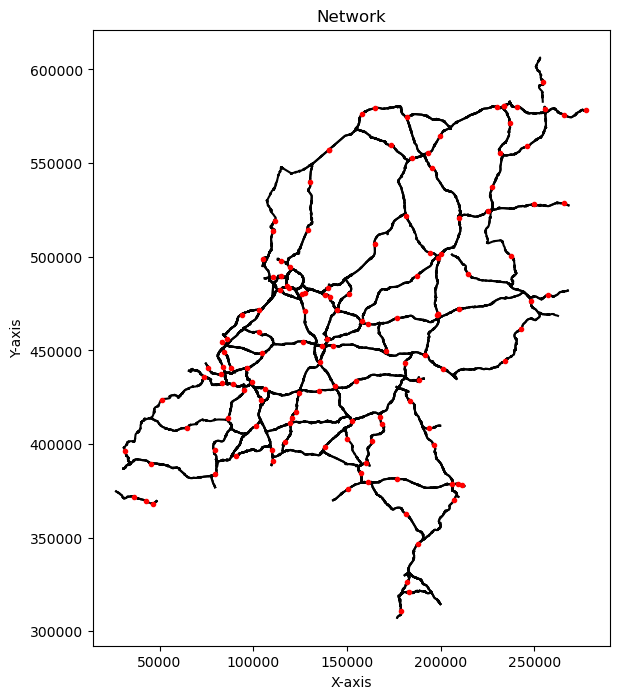

In [21]:
inspector_plotter(NWB_Graph, locs)